In [1]:
import os
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

#from data import loader_train, loader_val, loader_test
from train import train_model, test_model
from models import getModels
from utils import show_img
from trainers import Regression, Classification
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
from medmnist import PneumoniaMNIST
transfomrms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
test_dataset = PneumoniaMNIST(split="test",transform= transfomrms, download=True,size=28)
train_dataset = PneumoniaMNIST(split="train", transform= transfomrms,download=True,size=28)
val_dataset = PneumoniaMNIST(split="val",transform=transfomrms, download=True,size=28)

Using downloaded and verified file: C:\Users\34658\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\34658\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\34658\.medmnist\pneumoniamnist.npz


In [3]:
# start a new wandb run to track this script
import wandb
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="Test",
    name="MyComputer - Tests",

    # track hyperparameters and run metadata
    config={
        "N_images" : 1,
        "learning_rate": 0.001,
        "dataset": "Expert 1",
        "epochs": 50,
    }
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chermar (chermar-universitat-polit-cnica-de-val-ncia). Use `wandb login --relogin` to force relogin


In [4]:
import os
import sys
sys.path.append("..")


loader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
loader_val = DataLoader(val_dataset, batch_size=32, shuffle=True)
loader_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
batch = next(iter(loader_train))

print(batch[0].shape)

torch.Size([32, 1, 224, 224])


In [39]:
from resnet18 import ResNet, BasicBlock

In [6]:
from torch import nn
class CustomModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.classes = num_classes

        self._embeed = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) # 224
        )

        self._block1 = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(224, 224)
                )
                for i in range(1)
            ]
        )


        self._final = nn.Sequential(
            nn.Linear(64 * 224 * 224, num_classes)
        )

    def forward(self, x):
        x = self._embeed(x)

        for block in self._block1:
            x = block(x)
        x = x.view(x.size(0), -1)
        x = self._final(x)
        return x


In [28]:
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torchmetrics as tm
import matplotlib.pyplot as plt

class BinaryClassification(pl.LightningModule):
    def __init__(self, model, device):
        super().__init__()
        self.save_hyperparameters(ignore=("model",))

        self.model = model
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.confusion_matrix = tm.ConfusionMatrix(num_classes=model.classes, task="binary").to(device)

    def forward(self, x):
        return self.model(x)

    def training_step(self, x, y):

        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y.float())
        
        # Obtener predicciones con umbral 0.5
        y_pred = torch.sigmoid(y_hat) >= 0.5
        self.confusion_matrix.update(y_pred.int(), y.int())

        precision, recall, f1_score, accuracy = self.calculate_metrics_from_confusion_matrix()

        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy, prog_bar=True)

        return {"loss": loss, "accuracy": accuracy, "recall": recall, "precision": precision, "f1_score": f1_score}

    def validation_step(self, x, y):
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y.float())
        
        # Obtener predicciones con umbral 0.5
        y_pred = torch.sigmoid(y_hat) >= 0.5
        self.confusion_matrix.update(y_pred.int(), y.int())

        precision, recall, f1_score, accuracy = self.calculate_metrics_from_confusion_matrix()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", accuracy, prog_bar=True)

        return {"loss": loss, "accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score}

    def restart_epoch(self, plot=False):
        if plot:
            self.confusion_matrix.plot()
            plt.show()
        self.confusion_matrix.reset()

    def calculate_metrics_from_confusion_matrix(self):
        confusion_matrix = self.confusion_matrix.compute()
        true_positives = torch.diag(confusion_matrix)
        predicted_positives = confusion_matrix.sum(dim=0)
        actual_positives = confusion_matrix.sum(dim=1)

        precision = (true_positives / (predicted_positives + 1e-8)).mean()
        recall = (true_positives / (actual_positives + 1e-8)).mean()
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

        accuracy = true_positives.sum() / confusion_matrix.sum()
        return precision, recall, f1, accuracy

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(),
                                lr=0.001,
                                betas=(0.9, 0.999))

    def configure_scheduler(self, optimizer):
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                          factor=0.1,
                                                          patience=5)

In [34]:
batch = next(iter(loader_train))

x, y = batch

print(x.shape)
conv2d = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
x_out = conv2d(x)
print(x_out.shape)

torch.Size([32, 1, 224, 224])
torch.Size([32, 64, 224, 224])


In [40]:
#train a model
model =  ResNet(img_channels=1, num_layers=18, block=BasicBlock, num_classes=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainer = BinaryClassification(model, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_model(model, loader_train, loader_val, trainer, optimizer, device, num_epochs=10, classification = True)
test_model(model, loader_test, trainer, device, classification = True)

AttributeError: 'ResNet' object has no attribute 'classes'

Test model CustomModel - Loss: 0.69, Accuracy: 0.52, Recall: 0.51, Precision: 0.51, F1 Score: 0.51


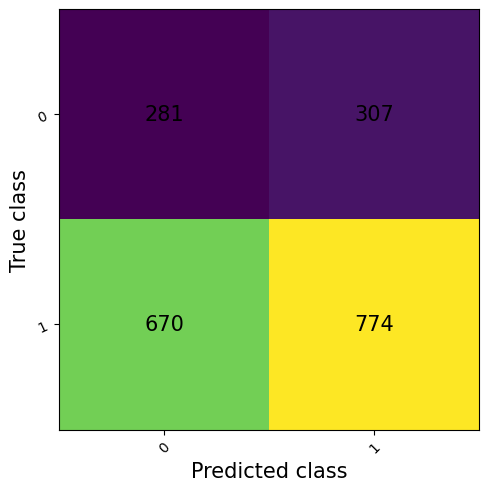

In [32]:
test_model(model, loader_test, trainer, device, classification = True)